In [213]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [214]:
df = pd.read_csv('Ruter-data.csv', sep=';')
df.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
0,15006-2020-08-10T10:24:00+02:00,10/08/2020,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,0,10:53:53,10:53:59,10:53:00,10:53:00,112,5
1,15002-2020-08-15T12:54:00+02:00,15/08/2020,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,0,13:12:20,13:12:26,13:12:00,13:12:00,112,5
2,15004-2020-08-03T09:54:00+02:00,03/08/2020,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,0,10:18:56,10:19:21,10:19:00,10:19:00,112,6
3,15003-2020-07-27T13:00:00+02:00,27/07/2020,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,1,13:52:04,13:52:26,13:51:00,13:51:00,112,10
4,15002-2020-08-27T07:15:00+02:00,27/08/2020,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,1,07:34:13,07:34:53,07:33:00,07:33:00,112,10


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   TurId                                      6000 non-null   object
 1   Dato                                       6000 non-null   object
 2   Fylke                                      6000 non-null   object
 3   Område                                     6000 non-null   object
 4   Kommune                                    6000 non-null   object
 5   Holdeplass_Fra                             6000 non-null   object
 6   Holdeplass_Til                             6000 non-null   object
 7   Linjetype                                  6000 non-null   object
 8   Linjefylke                                 6000 non-null   object
 9   Linjenavn                                  6000 non-null   object
 10  Linjeretning                        

In [231]:
# Convert date to numerical value for regression, can use more complex encoding like one-hot encoding for day, month, etc.
df['Dato'] = pd.to_datetime(df['Dato'], format='%d/%m/%Y')
df['Dato'] = df['Dato'].apply(lambda x: x.toordinal())
df['Year'] = df['Dato'].dt.year
df['Month'] = pd['Dato'].dt.month
df['Day'] = df['Dato'].dt.day

df.info()

ValueError: time data "737647" doesn't match format "%d/%m/%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [217]:
# Filter for a specific bus. Let's say bus number '37'
bus_data = df[df['Linjenavn'] == '37']
bus_data.info()



<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 194 to 5810
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   TurId                                      26 non-null     object
 1   Dato                                       26 non-null     int64 
 2   Fylke                                      26 non-null     object
 3   Område                                     26 non-null     object
 4   Kommune                                    26 non-null     object
 5   Holdeplass_Fra                             26 non-null     object
 6   Holdeplass_Til                             26 non-null     object
 7   Linjetype                                  26 non-null     object
 8   Linjefylke                                 26 non-null     object
 9   Linjenavn                                  26 non-null     object
 10  Linjeretning                             

In [218]:
bus_data.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord
194,3718-2020-08-21T07:59:00+02:00,737658,Oslo,Indre By,Gamle Oslo,Harald Hårdrådes plass (mot Galgeberg),Galgeberg (mot Etterstad),Lokal,Oslo,37,0,08:29:19,08:29:51,08:27:00,08:27:00,106,-2
207,3710-2020-08-12T07:15:00+02:00,737649,Oslo,Indre By,Sagene,Bjølsen (mot Sagene),Advokat Dehlis plass (mot Bentsebrua),Lokal,Oslo,37,0,07:19:39,07:20:07,07:19:00,07:19:00,106,3
358,3718-2020-08-10T07:59:00+02:00,737647,Oslo,Indre By,Sagene,Kristoffer Aamots gate (mot Maridalsveien),Kristoffer Aamots bro (mot Maridalsveien),Lokal,Oslo,37,0,08:00:30,08:00:56,08:00:00,08:00:00,106,4
1805,3702-2020-06-25T08:19:00+02:00,737601,Oslo,Indre By,Gamle Oslo,Etterstadkroken,Helsfyr (avstigning i Etterstadsletta),Lokal,Oslo,37,0,08:55:11,08:55:40,08:55:00,08:55:00,106,0
1903,3722-2020-08-12T07:10:00+02:00,737649,Oslo,Indre By,Sagene,Kristoffer Aamots gate (mot Sandakerveien),Nydalen T (mot Sandakerveien),Lokal,Oslo,37,1,07:40:39,07:41:05,07:42:00,07:42:00,106,6


In [219]:
# Calculate Q1, Q3, and IQR for the Passasjerer_Ombord column
Q1 = bus_data['Passasjerer_Ombord'].quantile(0.25)
Q3 = bus_data['Passasjerer_Ombord'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
bus_data_no_outliers = bus_data[(bus_data['Passasjerer_Ombord'] >= lower_bound) & 
                                (bus_data['Passasjerer_Ombord'] <= upper_bound)]

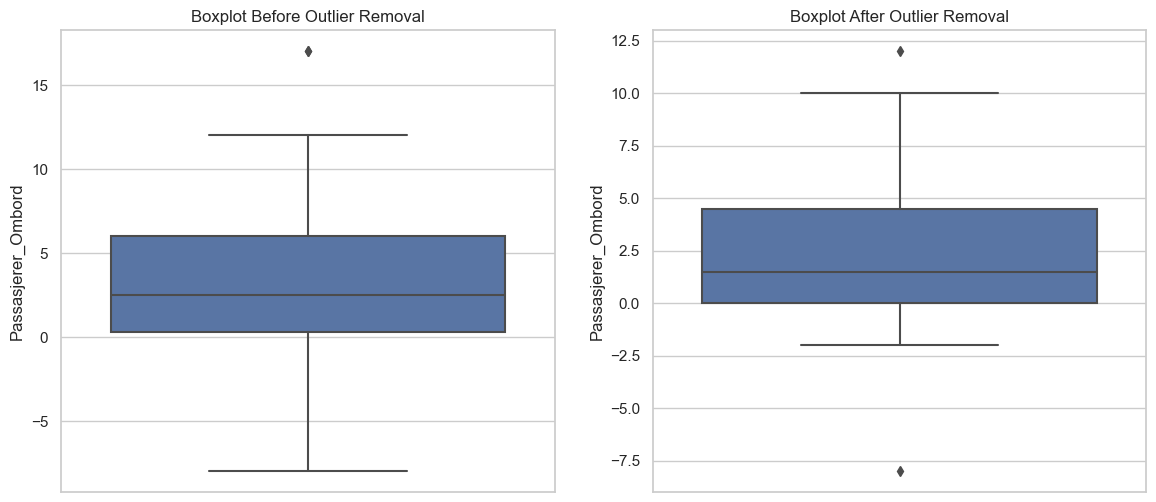

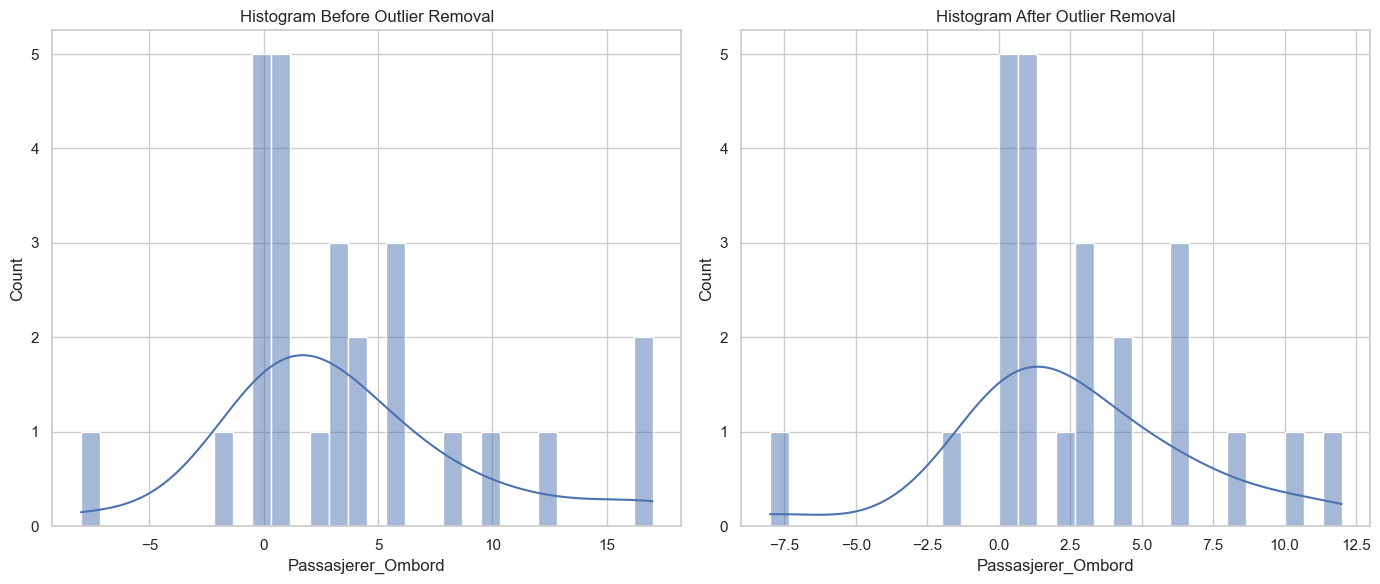

In [220]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Draw a boxplot of Passasjerer_Ombord column before outlier removal
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=bus_data['Passasjerer_Ombord'])
plt.title('Boxplot Before Outlier Removal')

# Draw a boxplot of Passasjerer_Ombord column after outlier removal
plt.subplot(1, 2, 2)
sns.boxplot(y=bus_data_no_outliers['Passasjerer_Ombord'])
plt.title('Boxplot After Outlier Removal')

plt.show()

# Draw histograms for both datasets
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(bus_data['Passasjerer_Ombord'], bins=30, kde=True)
plt.title('Histogram Before Outlier Removal')

plt.subplot(1, 2, 2)
sns.histplot(bus_data_no_outliers['Passasjerer_Ombord'], bins=30, kde=True)
plt.title('Histogram After Outlier Removal')

plt.tight_layout()
plt.show()

In [221]:
# Features and target data from the original dataset
x_original = bus_data[['Dato']]
y_original = bus_data['Passasjerer_Ombord']

# Splitting the original dataset into a training set and a test set
x_train_original, x_test_original, y_train_original, y_test_original = train_test_split(x_original, y_original, test_size=0.2, random_state=42)

# test_size 0.2 ensure that 20% of your data is used for testing, and randome_state = 41 ensures that the splitting of your data is reproducible. 



In [222]:
# Features and target data after outlier removal
x_clean = bus_data_no_outliers[['Dato']]
y_clean = bus_data_no_outliers['Passasjerer_Ombord']

# Splitting the cleaned dataset into a training set and a test set
x_train_clean, x_test_clean, y_train_clean, y_test_clean = train_test_split(x_clean, y_clean, test_size=0.2, random_state=42)

In [223]:
# Training the original model
model_original = LinearRegression()
model_original.fit(x_train_original, y_train_original)

# Predicting
y_pred = model_original.predict(x_test_original)

# Evaluation
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

def predict_passengers(date_str):
    date_num = pd.to_datetime(date_str, dayfirst=True).value
    return model_original.predict([[date_num]])[0]

print(predict_passengers("29-10-2023"))

Mean Squared Error: 17.125776039722723
R2 Score: -0.1743389284381296
6568730148619137.0


/Users/ingridlunde/anaconda3/envs/dave3625/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [226]:
# Training the cleaned model
model_clean = LinearRegression()
model_clean.fit(x_train_clean, y_train_clean)

# Predicting
y_pred_clean = model_clean.predict(x_test_clean)

# Evaluation
mse = mean_squared_error(y_test_clean, y_pred_clean)
r2 = r2_score(y_test_clean, y_pred_clean)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

def predict_passengers(date_str):
    date_num = pd.to_datetime(date_str, dayfirst=True).value
    return model_clean.predict([[date_num]])[0]

print('Predict passangers: ', predict_passengers("29-10-2023"))

Mean Squared Error: 35.79952895290377
R2 Score: -0.15333533997756987
Predict passangers:  7536528566085529.0


/Users/ingridlunde/anaconda3/envs/dave3625/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


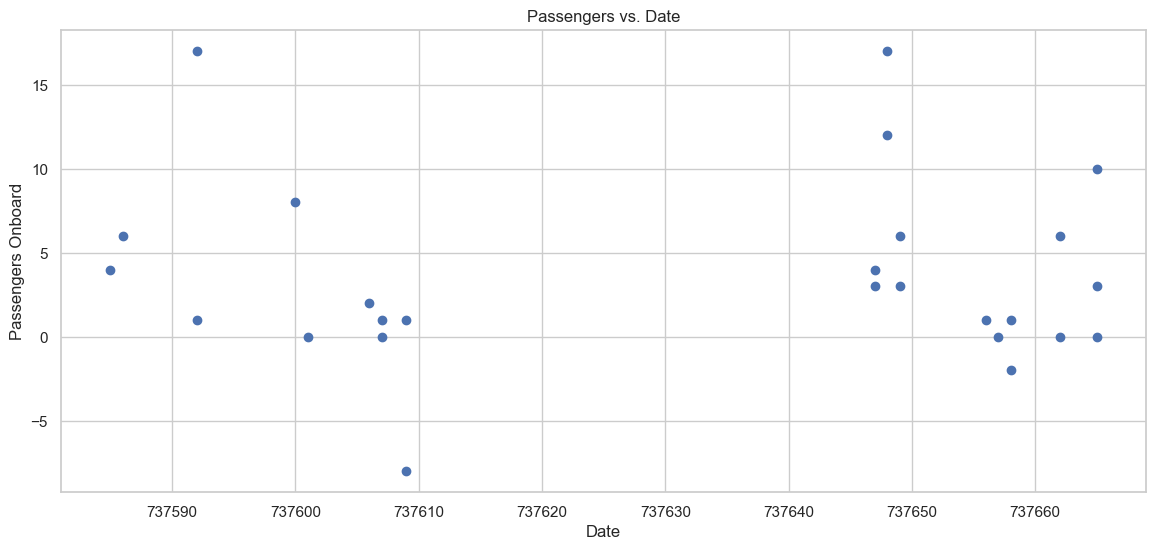

In [227]:
plt.figure(figsize=(14, 6))
plt.scatter(bus_data['Dato'], bus_data['Passasjerer_Ombord'])
plt.title('Passengers vs. Date')
plt.xlabel('Date')
plt.ylabel('Passengers Onboard')
plt.show()

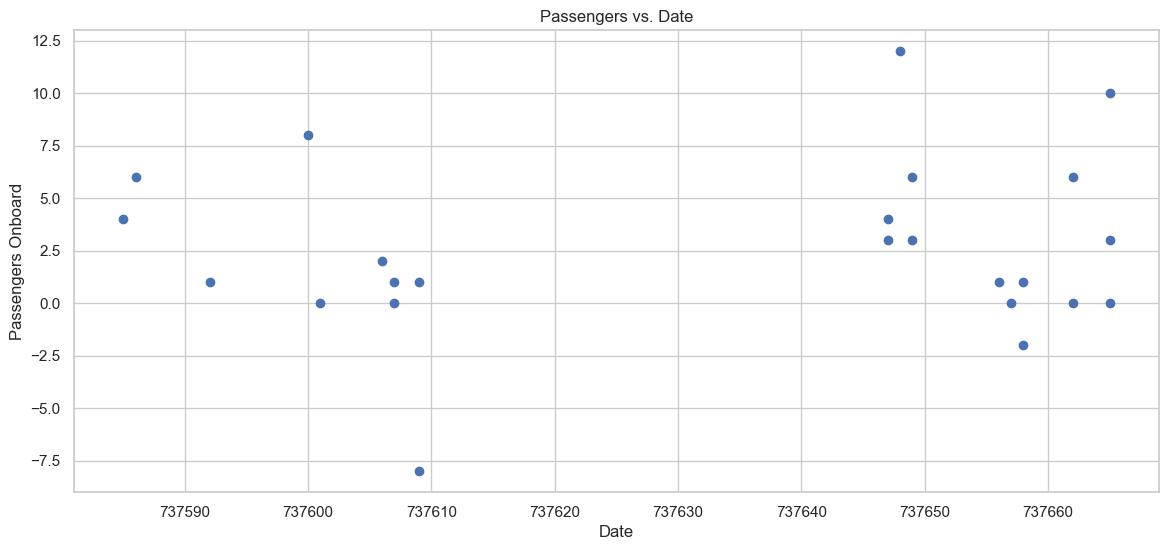

In [225]:
plt.figure(figsize=(14, 6))
plt.scatter(bus_data_no_outliers['Dato'], bus_data_no_outliers['Passasjerer_Ombord'])
plt.title('Passengers vs. Date')
plt.xlabel('Date')
plt.ylabel('Passengers Onboard')
plt.show()